<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/DME_late_fuse_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


In [3]:
tf.__version__,tf. config. list_physical_devices()

('2.4.1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Read, Split train_val & oversample train set


In [25]:
#ben 10 folder has file1 csv which has dme grades
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/file1.csv"
#images are from sigma 8 folder
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/ Ben_Processed 512_Size sigma8"
df = pd.read_csv(dataset_groundtruth_location)
img_loc=[]
for i in range(516):
  img_loc.append(dataset_images_location+'/'+str(i)+'.jpg')
df['processed_img_loc'] = img_loc
#print(df[:5][['processed_img_loc','Risk of macular edema ']])
test_df=df[-103:].reset_index(drop=True)[['processed_img_loc','Risk of macular edema ']]
df=df[0:413].reset_index(drop=True)[['processed_img_loc','Risk of macular edema ']]
train_df, val_df = train_test_split(df, test_size = 0.001, random_state = 25);
train_df.head()

,processed_img_loc,Risk of macular edema
224,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
23,/content/drive/My Drive/IDRid/B. Disease Gradi...,2
153,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
94,/content/drive/My Drive/IDRid/B. Disease Gradi...,2
325,/content/drive/My Drive/IDRid/B. Disease Gradi...,2


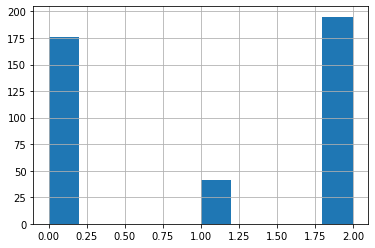

In [26]:
train_df['Risk of macular edema '].hist()

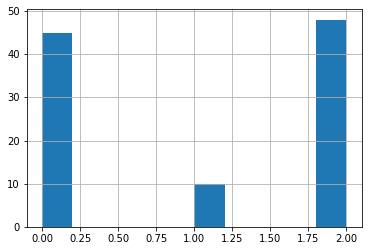

In [27]:
test_df['Risk of macular edema '].hist()

In [28]:
def balance_data(class_size, df):
    train_df = df.groupby(['Risk of macular edema ']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Risk of macular edema '].hist(figsize = (10, 5))
    return train_df

New Data Size: 585 Old Size: 412


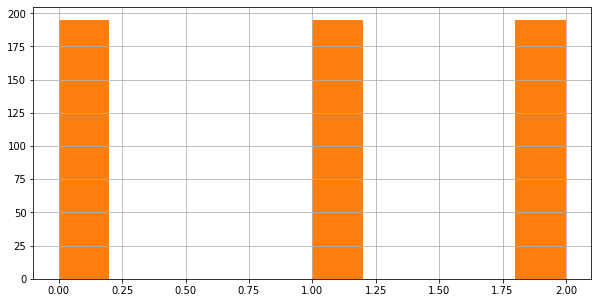

In [29]:
train_df = balance_data(train_df.pivot_table(index='Risk of macular edema ', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Risk of macular edema '].hist(figsize = (10, 5))

In [30]:
train_df['Risk of macular edema ']=train_df['Risk of macular edema '].astype('str')
#val_df['Retinopathy grade'] =val_df['Retinopathy grade'].astype('str')
test_df['Risk of macular edema '] =test_df['Risk of macular edema '].astype('str')

In [74]:
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=512,512

configs=dict( rescale=1/255.0,
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              zoom_range=[0.85,.98],
              width_shift_range=1.1,
              height_shift_range=0.05,
              fill_mode='nearest')
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(**configs,validation_split=0.1)
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='processed_img_loc', 
                                                    y_col='Risk of macular edema ',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training',
                                                    batch_size=BATCH_SIZE)
#val_datagen = ImageDataGenerator(**configs)
                                
val_generator = train_datagen.flow_from_dataframe(  train_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Risk of macular edema ',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  subset='validation',
                                                  batch_size=BATCH_SIZE
                                                  )

Found 527 validated image filenames belonging to 3 classes.
Found 58 validated image filenames belonging to 3 classes.


In [75]:
test_image_names = [];
test_image_names = test_df['processed_img_loc'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Risk of macular edema '];

test_images = np.zeros((103,512,512,3))
ind=0
for image_name in test_image_names:
    test_images[ind] = imread(image_name)
    ind+=1
test_images = test_images /255.0
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(test_labels)
test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 3)


In [76]:
test_datagen = ImageDataGenerator(**configs)
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Risk of macular edema ',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4
                                                  )

Found 103 validated image filenames belonging to 3 classes.


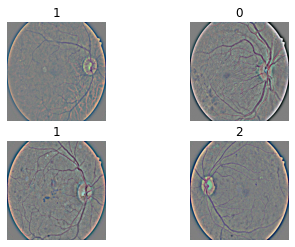

In [77]:
for i in range(4):
  ax=plt.subplot(2,2,i+1)
  plt.imshow(test_images[2*i+1])
  plt.title("{}".format(np.argmax(test_labels[2*i+1]))) 
  plt.axis('off')

1.0


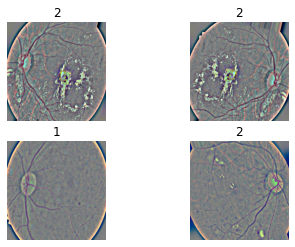

In [80]:
for i,(img,lbl) in enumerate(train_generator):
  print(np.max(img))
  for j in range(4):
    ax=plt.subplot(2,2,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

In [73]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from keras.models import Model

## Load Segmentation model 


In [81]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/Experimental models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/Experimental models/{}.h5".format(model_name))
    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [82]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
  
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
  
    # Save the input value
    X_shortcut = X
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X


In [84]:
def build_model(num_classes,model_name):
    IMG_SIZE=512
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_input')(input_0)
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB4':
      base_model = EfficientNetB4(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("seg_EX_ben_sigm8_5l_3f")
    se_model=load_seg_model("seg_SE_ben_sigm8_4l_4f")
    he_model=load_seg_model("seg_HE_ben_sigm8_6l_4f")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    se_model._name='model_se'
    he_model._name='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_he=he_model(input_0)

    #attention based input
    att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_he])
    W_g=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wg')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    #input image
    W_x=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    # convolve to  attention filter
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    att=keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    f_lesions=tf.keras.layers.Multiply()([att,input_0])
    
    #block1
    f_lesions=convolutional_block(f_lesions,3,(3,3,16),1,'a')
    f_lesions=identity_block(f_lesions,3,(3,3,16),1,'b')
    #block2
    f_lesions=convolutional_block(f_lesions,3,(16,16,32),2,'a')
    f_lesions=identity_block(f_lesions,3,(16,16,32),2,'b')
    #block3
    f_lesions=convolutional_block(f_lesions,3,(32,32,64),3,'a')
    f_lesions=identity_block(f_lesions,3,(32,32,64),3,'b')
    #block 4
    f_lesions=convolutional_block(f_lesions,3,(64,64,128),4,'a')
    f_lesions=identity_block(f_lesions,3,(64,64,128),4,'b')
    f_lesions=identity_block(f_lesions,3,(64,64,128),4,'c')
    
    #block 5
    f_lesions=convolutional_block(f_lesions,3,(128,128,256),5,'a')
    f_lesions=identity_block(f_lesions,3,(128,128,256),5,'b')
    f_lesions=identity_block(f_lesions,3,(128,128,256),5,'c')
    
    #pooling
    f_lesions=layers.GlobalAveragePooling2D()(f_lesions)
    top_dropout_rate = 0.2
   
    #predection_2
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)
  
    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [86]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
model=build_model(3,'EfficientNetB4')

seg_EX_ben_sigm8_5l_3f  Model loaded and compiled
seg_SE_ben_sigm8_4l_4f  Model loaded and compiled
seg_HE_ben_sigm8_6l_4f  Model loaded and compiled


In [87]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 22,204,247
Trainable params: 1,389,221
Non-trainable params: 20,815,026


In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [88]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
hist=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =20, callbacks = [es,rlr],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/20
132/132 [==============================] - 163s 810ms/step - loss: 1.2238 - accuracy: 0.5457 - val_loss: 0.9356 - val_accuracy: 0.5862
Epoch 2/20
132/132 [==============================] - 53s 404ms/step - loss: 0.7513 - accuracy: 0.6631 - val_loss: 1.3734 - val_accuracy: 0.5000
Epoch 3/20
132/132 [==============================] - 53s 403ms/step - loss: 0.6849 - accuracy: 0.6757 - val_loss: 0.6921 - val_accuracy: 0.7241
Epoch 4/20
132/132 [==============================] - 54s 406ms/step - loss: 0.6558 - accuracy: 0.7021 - val_loss: 0.5878 - val_accuracy: 0.7069
Epoch 5/20
132/132 [==============================] - 54s 408ms/step - loss: 0.5671 - accuracy: 0.7604 - val_loss: 0.5518 - val_accuracy: 0.7586
Epoch 6/20
132/132 [==============================] - 54s 407ms/step - loss: 0.5306 - accuracy: 0.7981 - val_loss: 0.5416 - val_accuracy: 0.7414
Epoch 7/20
132/132 [==============================] - 54s 406ms/step - loss: 0.5739 - accuracy: 0.7608 - val_loss: 0.5218 - val_a

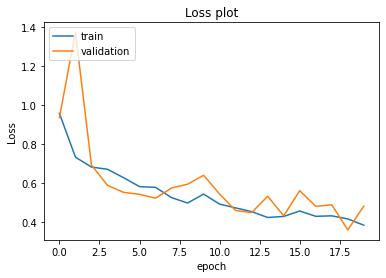

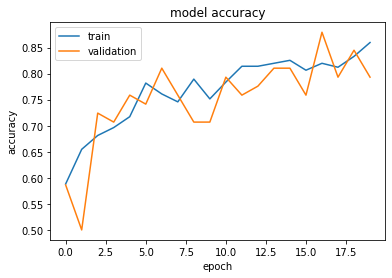

In [89]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [90]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score,accuracy_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

[[18  0  0]
 [ 3 15  1]
 [ 3  5 13]]
accuracy  0.7931034482758621  accuracy
quadratic kappa  0.7308882015024305


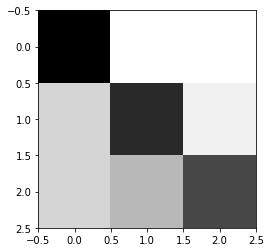

In [94]:
pred_y_=np.zeros((len(val_generator)*4-2,3))
val_y_=np.zeros((len(val_generator)*4-2,3))
for i,(img,lbl) in enumerate(val_generator):
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_y_[4*i:4*i+4,:]=lbl
  # run for loop len(val_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==len(val_generator)-1:
    break
pred_y_=pred_y_
cm=confusion_matrix(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
#print(" precision_score ",precision_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," precision")
print("accuracy ",accuracy_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(val_y_,axis=1)))

[[41  2  2]
 [ 4  6  0]
 [ 7 10 31]]
0.7572815533980582  accuracy
quadratic kappa  0.7096704249783174


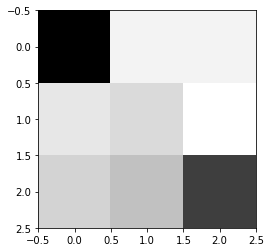

In [95]:
pred_y_=np.zeros((test_labels.shape))
for i in range(26):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

## acc with TTA

[[41  2  2]
 [ 3  7  0]
 [ 7 10 31]]
0.7669902912621359  accuracy
quadratic kappa  0.7135612628823819


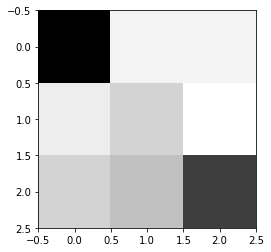

In [96]:
pred_y_tta=np.zeros((103,3))
test_y_=np.zeros((103,3))
for i,(img,lbl) in enumerate(test_generator):
  #print(img.shape,lbl.shape)
  pred_y_tta[4*i:4*i+4]=model.predict(img)
  test_y_[4*i:4*i+4,:]=lbl
  if i==25:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

## unfreeze and train

In [97]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:] == 'bn':
    layer.trainable=False
    count+=1
  if layer.name[-2:] in ['he','ex','se' ]:
    layer.trainable=False
    print(layer.name," freezed")
    count+=1
print(count-4," layers of bn freezed+ 4 seg model freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

model_ex  freezed
model_se  freezed
model_he  freezed
95  layers of bn freezed+ 4 seg model freezed
Total params: 22,204,247
Trainable params: 18,812,637
Non-trainable params: 3,391,610


In [98]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
from keras.callbacks import ModelCheckpoint
filepath="weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

opt = keras.optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist1=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =10, callbacks = [es,rlr,checkpoint],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/10
132/132 [==============================] - 145s 891ms/step - loss: 0.3250 - accuracy: 0.8919 - val_loss: 0.5298 - val_accuracy: 0.7931

Epoch 00001: val_accuracy improved from -inf to 0.79310, saving model to weights.01-0.79.hdf5
Epoch 2/10
132/132 [==============================] - 111s 836ms/step - loss: 0.3439 - accuracy: 0.8659 - val_loss: 0.3689 - val_accuracy: 0.8448

Epoch 00002: val_accuracy improved from 0.79310 to 0.84483, saving model to weights.02-0.84.hdf5
Epoch 3/10
132/132 [==============================] - 111s 842ms/step - loss: 0.2835 - accuracy: 0.8933 - val_loss: 0.3093 - val_accuracy: 0.8966

Epoch 00003: val_accuracy improved from 0.84483 to 0.89655, saving model to weights.03-0.90.hdf5
Epoch 4/10
132/132 [==============================] - 111s 841ms/step - loss: 0.2508 - accuracy: 0.8955 - val_loss: 0.3397 - val_accuracy: 0.9138

Epoch 00004: val_accuracy improved from 0.89655 to 0.91379, saving model to weights.04-0.91.hdf5
Epoch 5/10
132/132 [=======

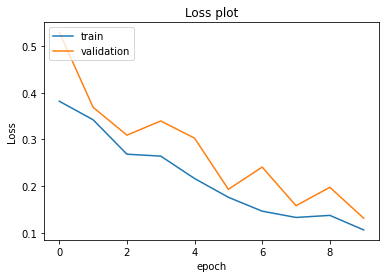

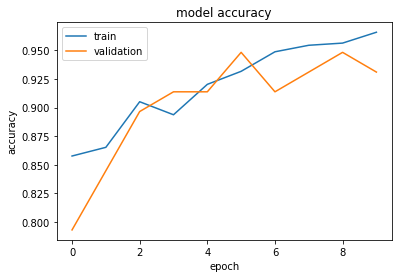

In [99]:
plt.plot(hist1.history["loss"])
plt.plot(hist1.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

[[41  2  2]
 [ 5  5  0]
 [ 6 10 32]]
0.7572815533980582  accuracy
quadratic kappa  0.7278511728228634


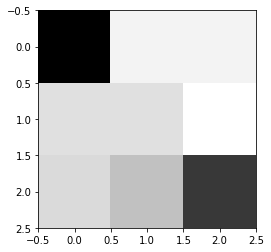

In [100]:
pred_y_=np.zeros((test_labels.shape))
for i in range(26):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

In [133]:
test_datagen = ImageDataGenerator( rescale=1/255.0,
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              zoom_range=[0.75,1],
              width_shift_range=1.1,
              height_shift_range=0.05,
              fill_mode='nearest')
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Risk of macular edema ',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4
                                                  )

Found 103 validated image filenames belonging to 3 classes.


[[40  3  2]
 [ 1  9  0]
 [ 4 12 32]]
0.7864077669902912  accuracy
quadratic kappa  0.7583957892327936


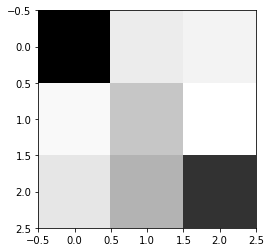

In [102]:
score=0
for j in range(25):
  for i,(img,lbl) in enumerate(test_generator):
    pred_y_tta[4*i:4*i+4]=model.predict(img)
    test_y_[4*i:4*i+4,:]=lbl
    if i==25:
      break
  cm_=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  score_=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  if score_>score:
    score=score_
    cm=cm_
print(cm)
plt.imshow(cm, cmap='binary')
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

(array([45.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0., 48.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

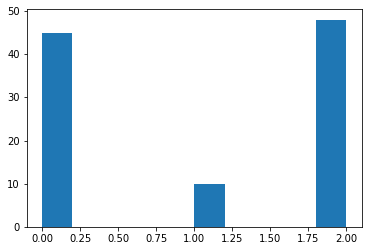

In [103]:
plt.hist(np.argmax(test_y_,axis=1))

## save model to disk

In [104]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/Experimental models/79_ben8_Late_fus_les_based_atten_dme.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/Experimental models/79_ben8_Late_fus_les_based_atten_dme.h5")
print("Saved model to disk")

Saved model to disk


## test on best validation model

In [105]:
model_1=build_model(3,'EfficientNetB4')
model_1.load_weights("weights.06-0.95.hdf5") 

seg_EX_ben_sigm8_5l_3f  Model loaded and compiled
seg_SE_ben_sigm8_4l_4f  Model loaded and compiled
seg_HE_ben_sigm8_6l_4f  Model loaded and compiled


[[41  2  2]
 [ 2  6  2]
 [ 6  7 35]]
0.7961165048543689  acuracy
quadratic kappa  0.7521787948457467


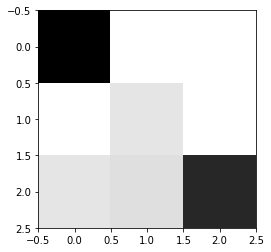

In [108]:
pred_y_=np.zeros((test_labels.shape))
for i in range(26):
  pred_y_[4*i:4*i+4]=model_1.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

[[40  2  3]
 [ 1  9  0]
 [ 3 11 34]]
0.8058252427184466  accuracy
quadratic kappa  0.7634836180341641


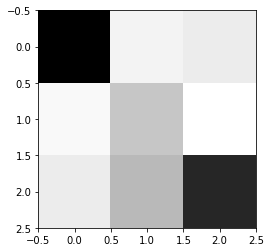

In [136]:
score=0
for j in range(25):
  for i,(img,lbl) in enumerate(test_generator):
    pred_y_tta[4*i:4*i+4]=model_1.predict(img)
    test_y_[4*i:4*i+4,:]=lbl
    if i==25:
      break
  cm_=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  score_=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  if score_>score:
    score=score_
    cm=cm_
print(cm)
plt.imshow(cm, cmap='binary')
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

In [113]:
# serialize model to JSON
model_json_1 = model_1.to_json()
with open("/content/drive/My Drive/IDRid/Experimental models/80_ben8_Late_fus_les_based_atten_dme.json", "w") as json_file:
    json_file.write(model_json_1)
# serialize weights to HDF5
model_1.save_weights("/content/drive/My Drive/IDRid/Experimental models/80_ben8_Late_fus_les_based_atten_dme.h5")
print("Saved model to disk")

Saved model to disk


##attention maps

In [132]:
layers_name=[]
index_att_layer=0
count=0
for i in model.layers:
  layers_name.append(i.name)
  if i.name=='tf.math.sigmoid_1':
    index_att_layer=count
  if i.name=='multiply_1':
    index_filt_layer=count
  count+=1
att=Model(inputs=model.input,outputs=model.layers[index_att_layer].output)
filtered_image=Model(inputs=model.input,outputs=model.layers[index_filt_layer].output) 

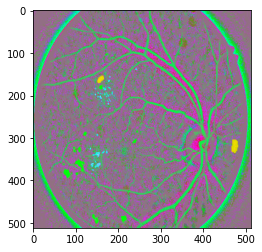

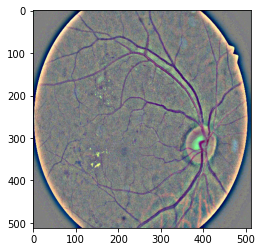

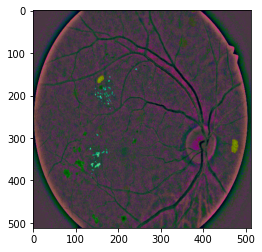

In [131]:
attention_map=att(test_images[19:20,:,:,:])
plt.imshow(attention_map[0,:,:,:])#/np.max(attention_map))
plt.show()
plt.imshow(test_images[19,:,:,:])
plt.show()
plt.imshow(filtered_image(test_images[19:20,:,:,:])[0,:,:,:])
plt.show()